# Tutorial
I’m going to explore the practical usages of topic model using the Gensim Library, such as finding structures for unknown datasets, classifying unlabeled data as well as improving accuracy of supervised learning.

## Introduction
This tutorial will introduce you several practical ways of using topic models with **Gensim Library**. In this tutorial I mainly focus on 2 kinds of topic models: *Latent Semantic Indexing (LSI)* and *Latent Dirichlet Allocation (LDA)*. In different cases, topic models can have different functionalities. Throughout this tutorial, you will learn how to use topic models to find structure for unknown datasets, classifying unlabeled data as well as improving the accuracy of supervised learning. Besides, in order to have a better views to the results, this tutorial also introduces some data visualization methods for reviewing topic models. 

We will cover the following topics in this tutorial:
- [Installing the libraries](#Installing-the-libraries)
- [Processing text](#Processing-text)
- [Training LSI model]
- [Training LDA model]
- [Finding structures of unknown text]
- [Classifying unlabeled data]

## Installing the libraries

Before getting started, you'll need to install the various libraries that we will use.  You can install Gensim, and NLTK using `pip`:

    $ pip3 install --upgrade gensim

    $ pip3 install -U nltk

When doing the examples, you might also need to use scikit-learn:

    $ pip3 install -U scikit-learn

In [157]:
import gensim
import nltk
import sklearn
import time
import random
import numpy as np

## Processing text
Here we use the [20 newsgroups text dataset](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html) from sklearn datasets. We also use the same processing method as homework-3. Additionally, we also remove all the stopwords as well as rarewords in the document. 

In [2]:
from sklearn.datasets import fetch_20newsgroups
from text_process import process, tokenize, remove_stopwords

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training and the other one for testing. Since for basic topic models there is no better way to truly evaluate the topics than manually examine the results and see whether they made sense. So here I use both training and testing sets for generating the topic model. 

In [3]:
newsgroups = fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'))

In [4]:
start = time.time()
docs_raw = [tokenize(doc) for doc in newsgroups.data]
docs = remove_stopwords(docs_raw)
k = 1000
sample_idxs = random.sample(range(len(docs)), k)  # 1000 samples from docs in order to do quick modeling
docs_sample = []
docs_raw_sample = []
for idx in sample_idxs:
    docs_sample.append(docs[idx]) 
    docs_raw_sample.append(docs_raw[idx])
end = time.time()

print("Processing time: " + str(end - start))

Processing time: 67.17970275878906


In [5]:
# Print out the num of docs and some of the processing results
print("The number of docs is: " + str(len(docs)))
print()
print("1st from samples of processed document: ")
print(' '.join(docs_sample[0]))
print()
print("1st from processed document:")
print(' '.join(docs[0]))

The number of docs is: 18846

1st from samples of processed document: 
nutrasweet synthetic sweetener couple thousand time sweeter sugar people concerned chemical body produce degrades nutrasweet thought form formaldehyde known methanol degredation pathway body us eliminate substance real issue whether level methanol formaldehyde produced high enough cause significant damage toxic living cell say consume phenylalanine nothing worry amino acid everyone us small quantity protein synthesis body people disease known missing enzyme necessary degrade compound eliminate body accumulate body high level toxic growing nerve cell therefore major problem young child around age woman pregnant disorder used leading cause brain damage infant easily detected birth one must simply avoid phenylalanine child pregnant

1st from processed document:
sure bashers pen fan pretty confused lack kind post recent pen massacre devil actually bit puzzled bit relieved however going put end non pittsburghers relief b

In [6]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary_all = gensim.corpora.Dictionary(docs)
dictionary_sample = gensim.corpora.Dictionary(docs_sample)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_all = [dictionary_all.doc2bow(doc) for doc in docs]
doc_term_matrix_sample = [dictionary_sample.doc2bow(doc) for doc in docs_sample]


## Training LSI model

In [9]:
topic_num = 30
Lsi = gensim.models.lsimodel.LsiModel
lsimodel = Lsi(doc_term_matrix_sample, num_topics=topic_num, id2word = dictionary_sample)

In [16]:
topic_words = lsimodel.show_topics(formatted=False)

In [118]:
print(type(topic_words[0][1]))
print(topic_words[0])

<class 'list'>
(0, [('planet', 0.38236509791739853), ('earth', 0.2698621605470751), ('spacecraft', 0.22547995194245324), ('moon', 0.22317058232746279), ('solar', 0.20645144690166056), ('system', 0.18370626220079442), ('surface', 0.16875190920047822), ('sun', 0.141458348797116), ('venus', 0.14025871884041188), ('atmosphere', 0.13681875977258845)])


In [136]:
print(lsimodel)

LsiModel(num_terms=14975, num_topics=30, decay=1.0, chunksize=20000)


Topic 0: planet earth spacecraft moon solar system surface sun venus atmosphere
Topic 1: adl bullock gerard group information fbi right say francisco san
Topic 2: m5 mv mf m8 mp md mj mh m4 mw
Topic 3: kinsey sex reisman adl child people one sexual would boy
Topic 4: space kinsey list post sex nasa shuttle sci reisman one
Topic 5: space kinsey jesus one sex people would list reisman day
Topic 6: jesus say matthew disciple mark mary heaven john people signal
Topic 7: de van het een en te utrecht op prof dr
Topic 8: armenian signal people dce sy dtr dte data ct dsr
Topic 9: day cancer armenian per bath remedy sy cure eat jesus
Topic 10: armenian sy day signal god dce would cancer know christian
Topic 11: win main detail mydisplay myhint event shuttle face line text
Topic 12: win shuttle face source list god constant post christian mass
Topic 13: constant mass god christian km velocity right radius earth bible
Topic 14: constant mass god christian km win velocity bit radius shuttle
Topic 

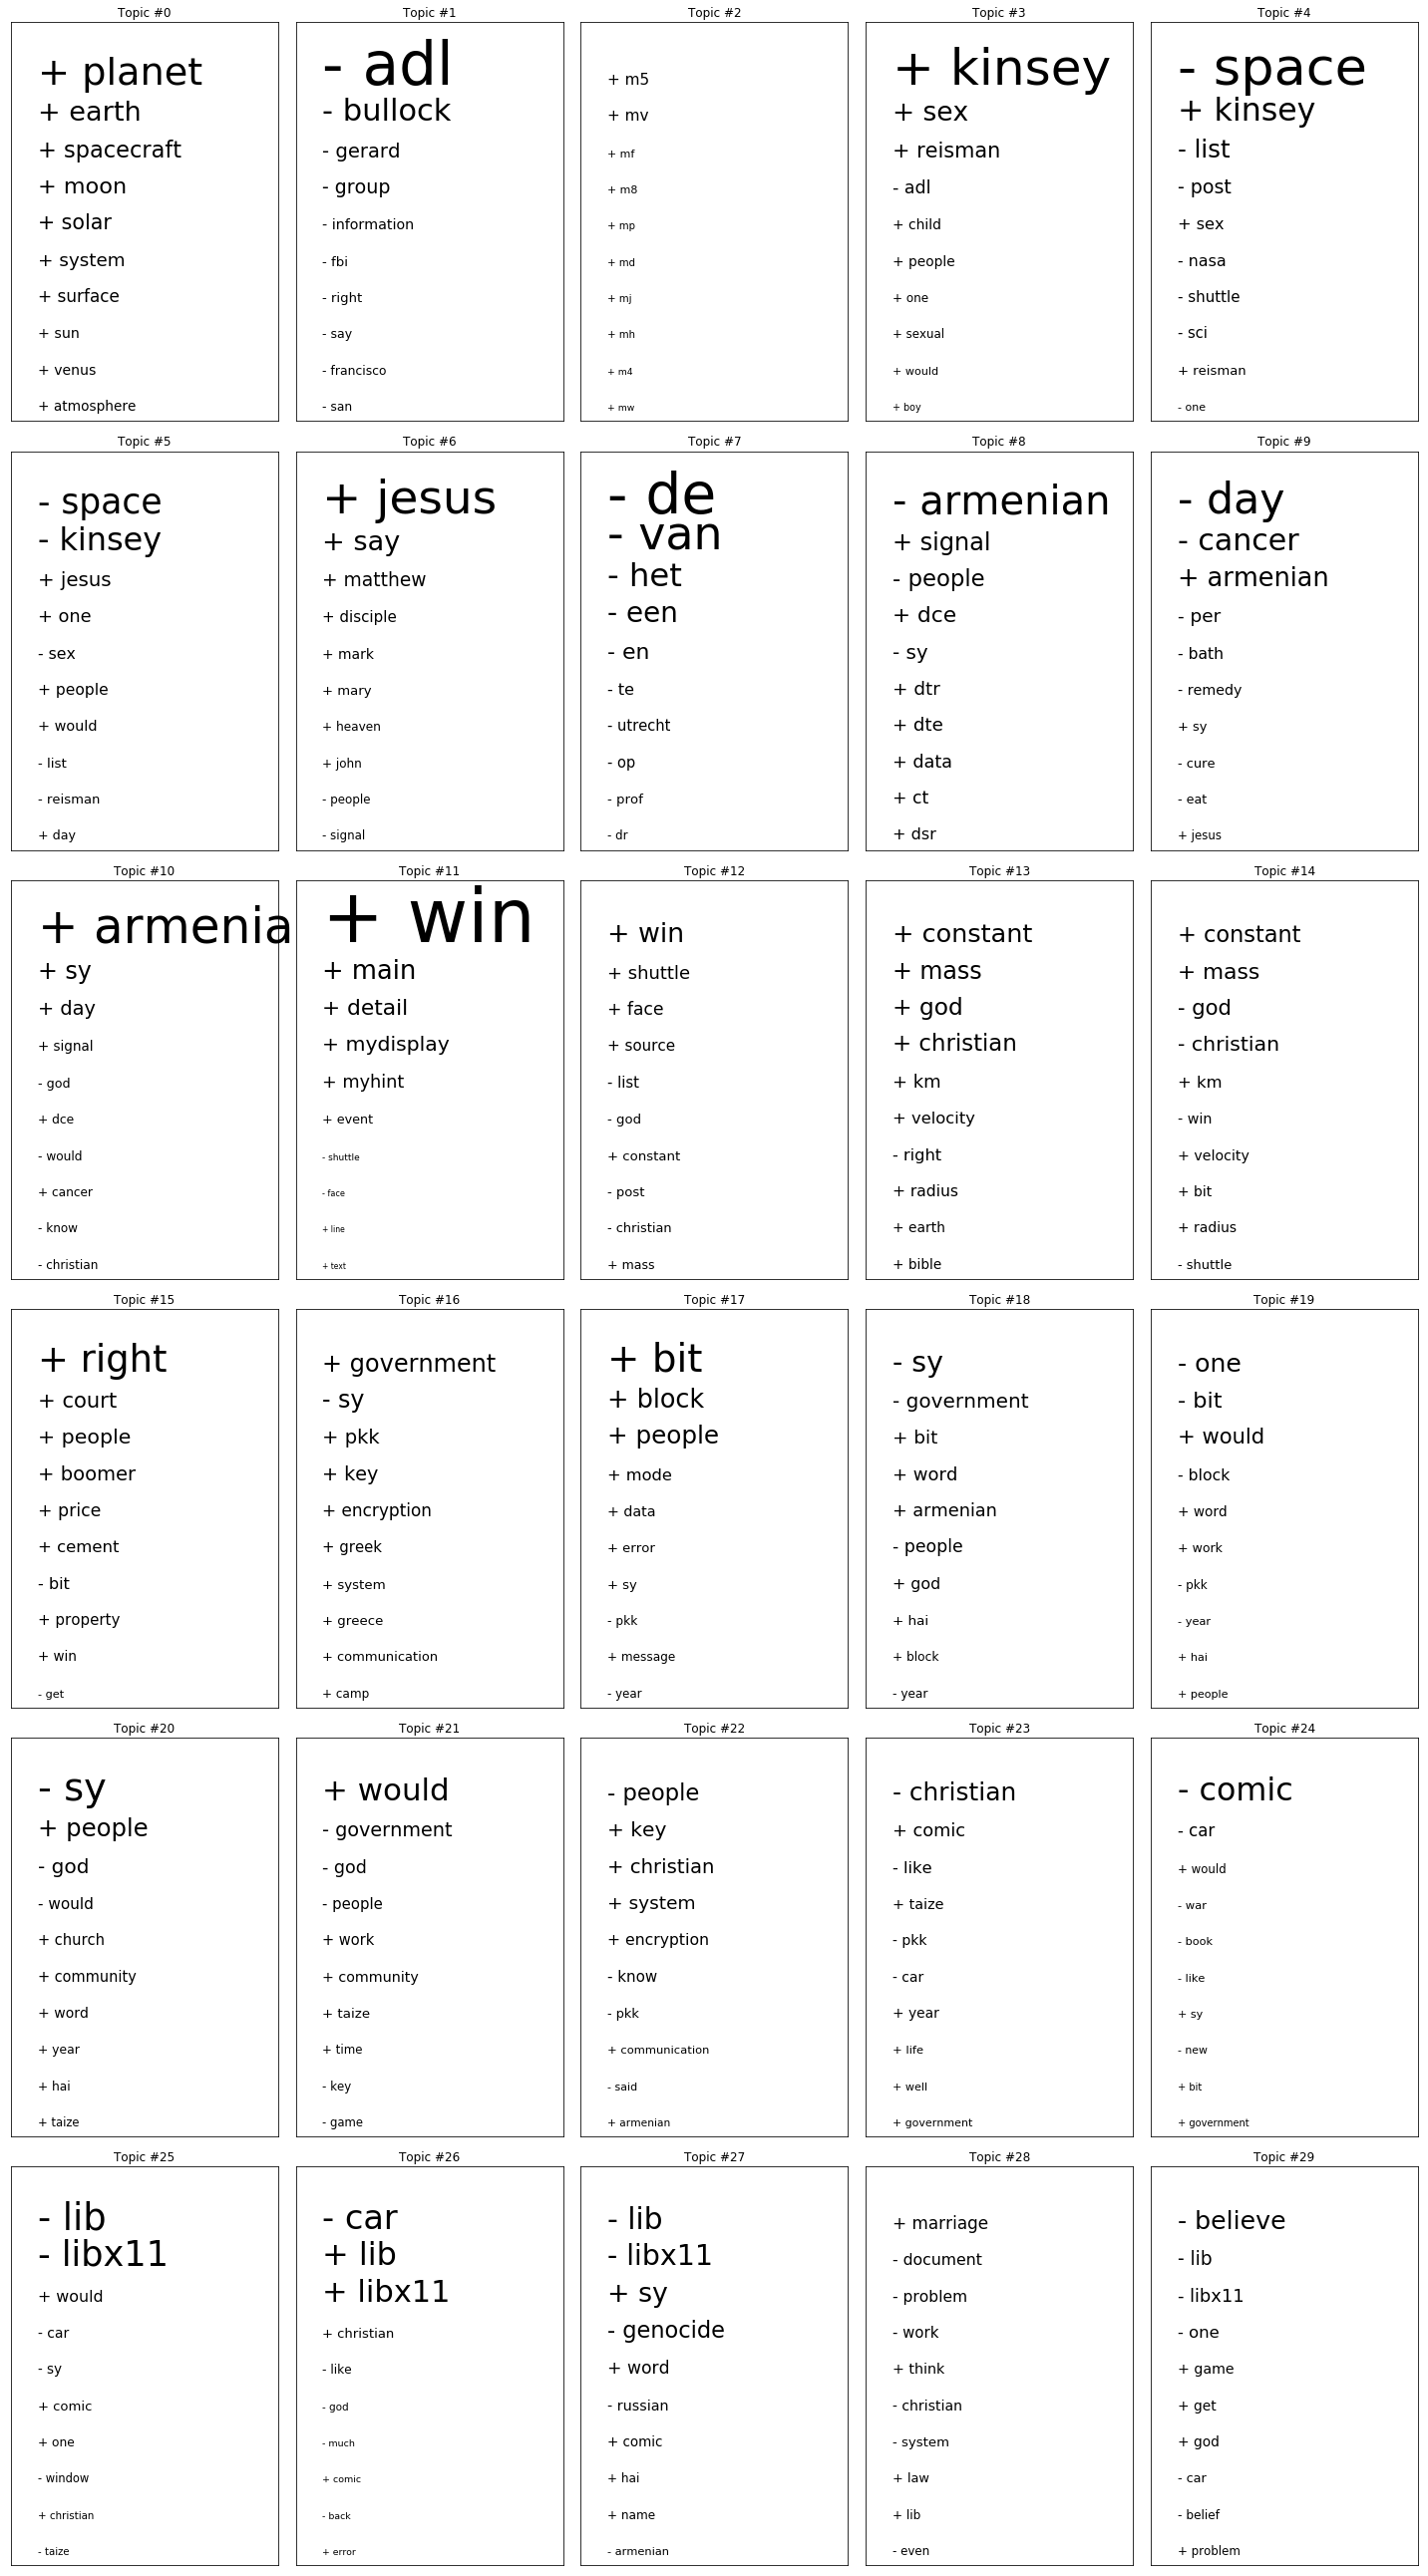

In [134]:
plot_topicwords(10, topic_words)

In [133]:
import matplotlib.pyplot as plt
import numpy as np
def plot_topicwords(num_top_words, topic_words):
    fontsize_base = 100
    import matplotlib as mpl
    mpl.rcParams['figure.figsize'] = (20,36)

    for t in range(topic_num):
        plt.subplot(6, 5, t + 1)  # plot numbering starts with 1
        plt.ylim(0, num_top_words + 1)  # stretch the y-axis to accommodate the words
        plt.xticks([])  # remove x-axis markings ('ticks')
        plt.yticks([]) # remove y-axis markings ('ticks')
        plt.title('Topic #{}'.format(t))
        top_words = [item[0] for item in topic_words[t][1]]
        print("Topic {}: {}".format(t, ' '.join(top_words)))
        top_words_shares = [float(item[1]) for item in topic_words[t][1]]
        for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
            if share < 0:
                word = '- ' + word
            else:
                word = '+ ' + word
            plt.text(0.1, num_top_words - 0.7 - i, word, fontsize=fontsize_base*abs(share))
    plt.tight_layout()
    plt.show()

Use tf-idf model to help get each document's topic

In [146]:

# tfidf = gensim.models.tfidfmodel(doc_term_matrix_sample)
tfidf = gensim.models.TfidfModel(doc_term_matrix_sample)

In [155]:
corpus_tfidf = tfidf[doc_term_matrix_sample]
for doc in corpus_tfidf:
    print(doc)
    break

[(0, 0.10718369043255328), (1, 0.09138037337763687), (2, 0.07243254632416626), (3, 0.10718369043255328), (4, 0.04422058534001797), (5, 0.07131944687187088), (6, 0.08327419472543168), (7, 0.2941698925759944), (8, 0.08327419472543168), (9, 0.10696943854139129), (10, 0.15885125104815215), (11, 0.08557721805746259), (12, 0.10934928630086235), (13, 0.08557721805746259), (14, 0.06747087767051525), (15, 0.11913843828611409), (16, 0.058833978515198886), (17, 0.15885125104815215), (18, 0.10718369043255328), (19, 0.11913843828611409), (20, 0.11913843828611409), (21, 0.09522894257899248), (22, 0.07942562552407607), (23, 0.10718369043255328), (24, 0.07131944687187088), (25, 0.21436738086510657), (26, 0.050991118801314114), (27, 0.10718369043255328), (28, 0.060477798470605464), (29, 0.0564007881091317), (30, 0.23827687657222818), (31, 0.0882358633790827), (32, 0.10403199565762217), (33, 0.0882358633790827), (34, 0.05831910280460624), (35, 0.11766795703039777), (36, 0.08327419472543168), (37, 0.1272

In [149]:
corpus_lsi = lsimodel[corpus_tfidf]

In [156]:
print(' '.join(docs_sample[2]))
print(corpus_lsi[2])

thanks etymology lesson actually know orthodox mean avoiding question however body theology version orthodoxy come seem simply saying whatever understand bible say orthodox obviously mistaken since many many people read bible many agree point robert interpretation correct orthodox one whole string began response attack mormonism one attacking personal belief tendency present orthodoxy much care believe bible present personal understanding orthodox one never attacked specific belief approach remember stating people depend solely bible view indeed proof bible interpreted many way whole point along specific belief business pretend anything personal intepretation careful cry heresy based private belief system
[(0, 0.048222506724624865), (1, -0.03142905064634392), (2, 0.011098232896429002), (3, 0.09979634047787292), (4, -0.053957374562609926), (5, 0.11925365336586981), (6, -0.026817711961162817), (7, 0.004881490915468781), (8, -0.028202392265952305), (9, 0.022578559122929748), (10, -0.08119

In [217]:
def plot_topic_share(docs_topic, topic_num):
    plots = []
    N = len(docs_topic)
    height_cumulative = np.zeros(N)
    ind = np.arange(N)
    width = 0.2
    
    tmp = [[abs(val[1]) for val in doc_topic] for doc_topic in docs_topic]
    for val_ls in tmp:
        val_sum = sum(val_ls)
        for i in range(len(val_ls)):
            val_ls[i] = val_ls[i] / val_sum
    
    doctopic = np.array(tmp)
    
    mpl.rcParams['figure.figsize'] = (20,10)
    
    for k in range(topic_num):
        color = plt.cm.nipy_spectral(k/topic_num, 1)
        if k == 0:
            p = plt.bar(ind, doctopic[:, k], width, color=color)
        else:
            p = plt.bar(ind, doctopic[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += doctopic[:, k]
        plots.append(p)
    
    plt.ylim((0, 1)) 
    plt.ylabel('Topics')
    plt.title('Topics in docs')
    
    
    plt.xticks(ind+width/2, list(range(N)))
    plt.yticks(np.arange(0, 1, 10))
    
    topic_labels = ['Topic #{}'.format(k) for k in range(topic_num)]
    plt.legend([p[0] for p in plots], topic_labels)
    plt.show()

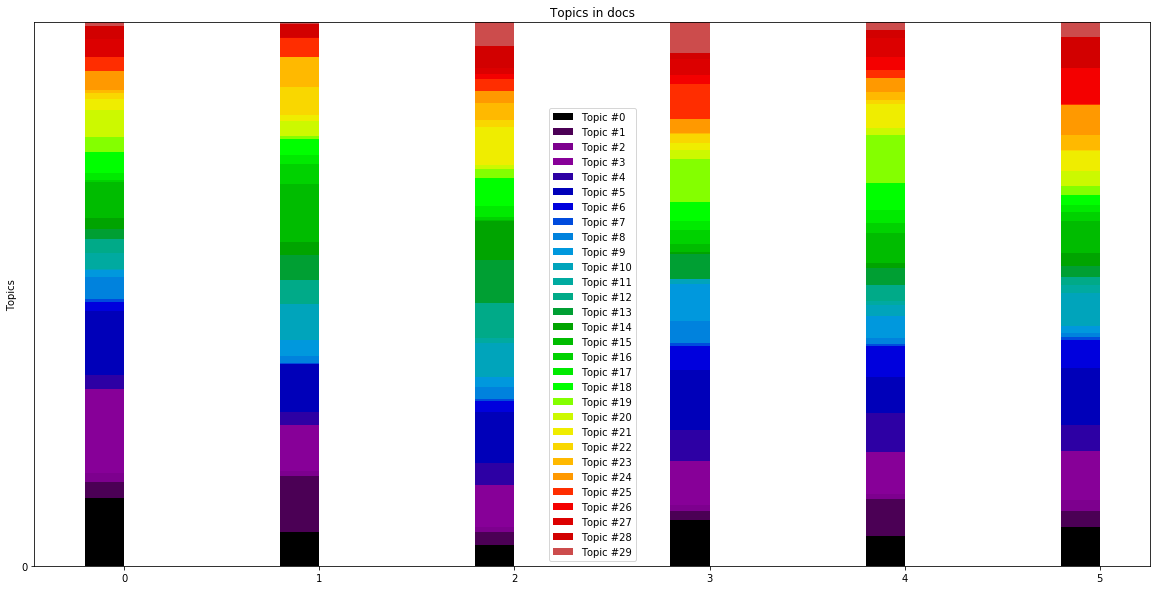

In [218]:
plot_topic_share(corpus_lsi[:6], topic_num)

In [225]:
def plot_topic_val(docs_topic, topic_num):
    tmp = [[(val[1]) for val in doc_topic] for doc_topic in docs_topic]
    doctopic = np.array(tmp)
    topic_labels = ['Topic #{}'.format(k) for k in range(topic_num)]
    
    plt.pcolor(doctopic, norm=None, cmap='nipy_spectral')
    mpl.rcParams['figure.figsize'] = (20,10)
    
    plt.yticks(np.arange(doctopic.shape[0])+0.5, list(range(doctopic.shape[0])));
    plt.xticks(np.arange(doctopic.shape[1])+0.5, topic_labels);
    plt.gca().invert_yaxis()
    plt.xticks(rotation=90)
    plt.colorbar(cmap='nipy_spectral')
    plt.tight_layout()
    plt.show()

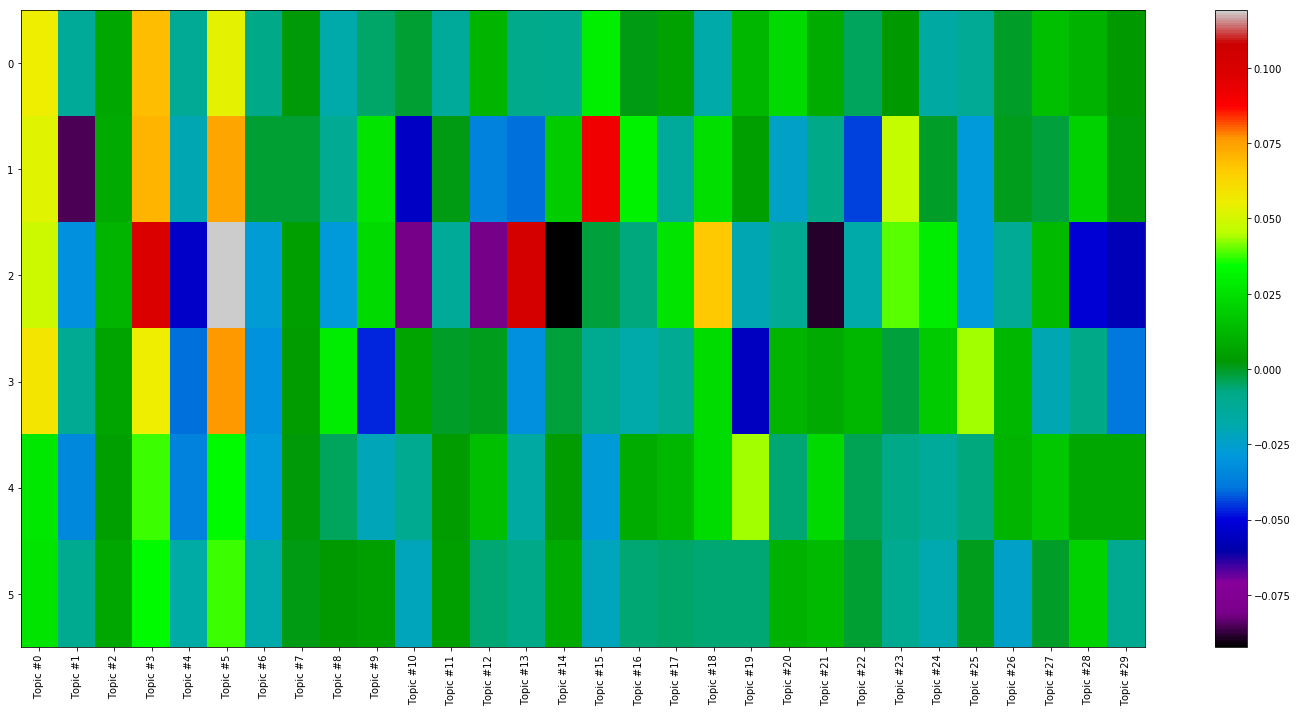

In [226]:
plot_topic_val(corpus_lsi[:6], topic_num)

Processing with the data from 20newsgroups

In [50]:
id2word = gensim.corpora.Dictionary.load_from_text('data/wiki_en_wordids.txt')

In [55]:
print(len(id2word))

100000


In [16]:
from sklearn.datasets import fetch_20newsgroups

In [30]:
newsgroups = fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'))

In [31]:
from pprint import pprint
pprint(list(newsgroups.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [32]:
print(type(newsgroups.data[0]))

<class 'str'>


In [46]:
print(len(newsgroups.data))
print(newsgroups.data[200])

18846

Jesus did and so do I.

Peace be with you,


In [47]:
doc_clean = [process(doc).split() for doc in newsgroups.data]

NameError: name 'process' is not defined

In [5]:
# test for simple samples

doc1 = "Sugar is bad to consume. My sister likes to have sugar, but not my father."
doc2 = "My father spends a lot of time driving my sister around to dance practice."
doc3 = "Doctors suggest that driving may cause increased stress and blood pressure."
doc4 = "Sometimes I feel pressure to perform well at school, but my father never seems to drive my sister to do better."
doc5 = "Health experts say that Sugar is not good for your lifestyle."

doc_complete = [doc1, doc2, doc3, doc4, doc5]

In [6]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete]   

In [37]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [41]:
# Creating the object for LDA model using gensim library

start = time.time()
Lda = gensim.models.ldamodel.LdaModel
Lsi = gensim.models.lsimodel.LsiModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)
lsimodel = Lsi(doc_term_matrix, num_topics=3, id2word = dictionary)

end = time.time()

print(str(end - start))

704.1523542404175


In [42]:
print(ldamodel.print_topics(num_topics=3, num_words=10))

[(0, '0.005*"one" + 0.005*"would" + 0.004*"year" + 0.004*"get" + 0.003*"time" + 0.003*"like" + 0.003*"game" + 0.003*"well" + 0.003*"also" + 0.003*"know"'), (1, '0.009*"1" + 0.007*"x" + 0.006*"2" + 0.006*"0" + 0.006*"file" + 0.004*"window" + 0.004*"use" + 0.004*"system" + 0.004*"image" + 0.004*"3"'), (2, '0.007*"would" + 0.007*"one" + 0.007*"people" + 0.006*"god" + 0.004*"think" + 0.004*"say" + 0.004*"it" + 0.004*"know" + 0.004*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxax" + 0.003*"like"')]


In [43]:
print(lsimodel.print_topics(num_topics=3, num_words=10))

[(0, '0.976*"x" + 0.097*"file" + 0.079*"entry" + 0.052*"program" + 0.051*"0" + 0.035*"oname" + 0.033*"output" + 0.030*"char" + 0.030*"line" + 0.028*"section"'), (1, '0.700*"0" + 0.470*"1" + 0.390*"2" + 0.205*"3" + 0.155*"4" + 0.080*"5" + 0.078*"6" + -0.069*"x" + 0.068*"7" + 0.053*"8"'), (2, '1.000*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxax" + 0.008*"mg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9v" + 0.004*"14" + 0.004*"part" + 0.003*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxaxq" + 0.002*"end" + 0.002*"m8axaxaxaxaxaxaxaxaxaxaxaxaxax" + 0.001*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxasq" + 0.001*"maxaxaxaxaxaxaxaxaxaxaxaxaxax1f" + -0.001*"0"')]


In [9]:
from gensim.test.utils import common_dictionary, common_corpus
from gensim.models import LsiModel


In [11]:
print(common_dictionary)

Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...)
